# Import Package

In [3]:
import numpy as np
import pandas as pd 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
print(f'''
{np.__version__},
{pd.__version__},
{tf.__version__}''')


1.22.4,
1.4.2,
2.9.1


In [ ]:
!python --version

Python 3.8.10


# Import Dataset

In [4]:
rating = pd.read_csv('rating_kuliner_bali.csv')
kuliner = pd.read_csv('kuliner.csv')
user = pd.read_csv('user.csv')

# Persiapan Dataset

In [5]:
# Merubah data agar hanya dari Kota Bali

kuliner = kuliner[kuliner['City']=='Bali']
kuliner.head()


,Place_Id,Kuliner_Name,Description,Category,alamat,City,Rating,Coordinate,Lat,Long,Price,Images
33,41,JEBAK ( Jejak Bali Kuliner),Tempat berkumpulnya para vendor makanan dengan...,Makanan,"Jl. Teuku Umar No.212, Dauh Puri Kauh, Kec. De...",Bali,4.3,"{'lat': -8.680513334370504, 'lng': 115.2015822...",-8.680.513.334,1.152.015.822,150000,https://www.denpasarkota.go.id/uploads/berita/...
34,42,Pondok Seafood Cak Har,Ikan bakarnya enaaak... ikan baronangnya neasr...,Makanan,"Jl. Teuku Umar No.222, Dauh Puri Kauh, Kec. De...",Bali,4.3,"{'lat': -8.680896572457401, 'lng': 115.2005028...",-8.680.896.572,1.152.005.028,100000,https://b.zmtcdn.com/data/pictures/5/1705375/9...
35,43,Bale Udang Mang Engking Kuta,Tempat makan yg unik memiliki gubug-gubug diat...,Makanan,"Jl. Nakula No.88, Pemecutan Klod, Kec. Denpasa...",Bali,4.4,"{'lat': -8.699604043838137, 'lng': 115.1830186...",-8.699.604.044,1.151.830.187,-,https://media-cdn.tripadvisor.com/media/photo-...
36,44,Makan Place,Makan Place memperkenalkan berbagi makanan unt...,Makanan,"Jl. Padma No.1, Legian, Kec. Kuta, Kabupaten B...",Bali,4.4,"{'lat': -8.706036539694576, 'lng': 115.1682776...",-870.603.654,1.151.682.777,-,https://media-cdn.tripadvisor.com/media/photo-...
37,45,Kedaton Restaurant,"Datang ke sini saat makan siang hari kerja, ti...",Makanan,"Jl. Raya Kuta No.62/3, Kuta, Kec. Kuta, Kabupa...",Bali,4.3,"{'lat': -8.717579890571328, 'lng': 115.1808039...",-8.717.579.891,115.180.804,-,https://b.zmtcdn.com/data/reviews_photos/eb9/b...


In [6]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,56,3
1,1,55,2
2,1,50,5
3,1,74,3
4,1,53,4


In [7]:
df = rating.copy()

In [8]:
#ENCODING
def dict_encoder(col, data=df):
  unique_val = data[col].unique().tolist()
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

In [9]:
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')
df['user'] = df['User_Id'].map(user_to_user_encoded)

In [11]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

In [12]:
# Mendapatkan jumlah user dan hotel
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)
# mengubah nilai rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)
# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Ratings']), max(df['Place_Ratings'])

In [13]:
print(f'Jumlah user : {num_users}')
print(f'Jumlah kuliner : {num_place}')
print(f'Rating minimum : {min_rating}')
print(f'Rating maximum : {max_rating}')

Jumlah user : 300
Jumlah kuliner : 47
Rating minimum : 1.0
Rating maximum : 5.0


In [14]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head()

,User_Id,Place_Id,Place_Ratings,user,place
6252,188,82,3.0,187,41
4684,142,62,2.0,141,11
1731,54,64,3.0,53,16
4742,144,67,3.0,143,17
4521,138,54,5.0,137,23


# Splitting Dataset

In [15]:
# Mambuat Variable x
x = df[['user', 'place']].values
# membuat Variable y
y = df['Place_Ratings'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values

# split dataset
indices = int(0.8*df.shape[0])
x_train, x_test, y_train, y_test = (x[:indices],
                                    x[indices:],
                                    y[:indices],
                                    y[indices:]
                                    )
print(f'x_train : {x_train.shape}')
print(f'x_test : {x_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

x_train : (8000, 2)
x_test : (2000, 2)
y_train : (8000,)
y_test : (2000,)


In [16]:
class Recommended(keras.Model):
  def __init__(self,num_users, num_places, embedding_size, **kwargs):
    super(Recommended, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(num_users,
                                           embedding_size,
                                           embeddings_initializer = 'he_normal',
                                           embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users,1)
    self.places_embedding = layers.Embedding(num_places,
                                             embedding_size,
                                             embeddings_initializer='he_normal',
                                             embeddings_regularizer= keras.regularizers.l2(1e-6)
                                             )
    self.places_bias = layers.Embedding(num_places,1)

  def call(self, inputs):
    user_vec = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:,0])
    places_vec = self.places_embedding(inputs[:,1])
    places_bias = self.places_bias(inputs[:,1])

    dot_user_places = tf.tensordot(user_vec, places_vec, 2)

    x = dot_user_places + user_bias + places_bias

    return tf.nn.sigmoid(x)


In [17]:
model = Recommended(num_users, num_place, 50)

model.compile(loss = keras.losses.BinaryCrossentropy(),
              optimizer= keras.optimizers.Adam(learning_rate=0.0004),
              metrics=[keras.metrics.RootMeanSquaredError()]
              )

# training Model

In [18]:
history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 100,
    validation_data = (x_test, y_test)
)

Epoch 1/100
250/250 [==============================] - 2s 3ms/step - loss: 0.7401 - root_mean_squared_error: 0.3744 - val_loss: 0.7240 - val_root_mean_squared_error: 0.3642
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 0.7442 - root_mean_squared_error: 0.3767 - val_loss: 0.7231 - val_root_mean_squared_error: 0.3637
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.7339 - root_mean_squared_error: 0.3708 - val_loss: 0.7229 - val_root_mean_squared_error: 0.3634
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.7280 - root_mean_squared_error: 0.3672 - val_loss: 0.7215 - val_root_mean_squared_error: 0.3628
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.7285 - root_mean_squared_error: 0.3671 - val_loss: 0.7213 - val_root_mean_squared_error: 0.3625
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.7305 - root_mean_squared_error: 0.3688 - val_loss: 0.7199 

# Evaluasi Model

In [21]:
model.evaluate(x=x_test, y=y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.7072 - root_mean_squared_error: 0.3545


[0.7072129845619202, 0.3545273542404175]

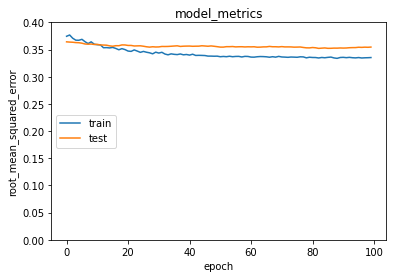

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.4)
plt.legend(['train', 'test'], loc='center left')
plt.show()

# Penerapan Model

In [22]:
kuliner.columns

Index(['Place_Id', 'Kuliner_Name', 'Description', 'Category', 'alamat', 'City',
       'Rating', 'Coordinate', 'Lat', 'Long', 'Price', 'Images'],
      dtype='object')

In [23]:
place_df = kuliner[['Place_Id', 'Kuliner_Name', 'Description', 'Category', 'alamat', 'City', 'Rating',
       'Coordinate','Lat','Long','Price','Images']]
place_df.columns = ['Place_Id', 'Kuliner_Name', 'Description', 'Category', 'alamat', 'City', 'Rating',
       'Coordinate','Lat','Long','Price','Images']
df = rating.copy()

In [24]:
# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

In [25]:
# Membuat data lokasi yang belum dikunjungi user
place_not_visited = place_df[~place_df['Place_Id'].isin(place_visited_by_user.Place_Id.values)]['Place_Id'] 
place_not_visited = list(
    set(place_not_visited).intersection(set(place_to_place_encoded.keys()))
)
 
place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

In [26]:
# Mengambil top 5 recommendation
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-5:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]
 

print('')
print('----' * 15)
print('Top 5 place recommendation')
print('----' * 15)
 
recommended_place = place_df[place_df['Place_Id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.Kuliner_Name, '\n    ', row.alamat, ',', 'Rating Kuliner ', row.Rating,'\n')

print('==='*15)


------------------------------------------------------------
Top 5 place recommendation
------------------------------------------------------------
1 . Layana Warung 
     Jl. Raya Goa Gajah, Bedulu, Kec. Blahbatuh, Kabupaten Gianyar, Bali 80582 , Rating Kuliner  4.5 

2 . Warung Be Pasih 
     Jl. Pemuda III No.24, Renon, Denpasar Selatan, Kota Denpasar, Bali 80239 , Rating Kuliner  4.5 

3 . Nasi Ayam Kedewatan Ibu Mangku - Renon (Cabang I) 
     Jl. Teuku Umar No.8, Dauh Puri Kauh, Kec. Denpasar Bar., Kota Denpasar, Bali 80113 , Rating Kuliner  4.4 

4 . Warung Makan Teges 
     Jalan Cok Rai Pudak,Peliatan,Ubud,Kabupaten Gianyar,Bali 80571, Peliatan, Kecamatan Ubud, Kabupaten Gianyar, Bali 80571 , Rating Kuliner  4.5 

5 . Laka Leke Restaurant 
     Jl. Nyuh Bojog No.32, MAS, Kecamatan Ubud, Kabupaten Gianyar, Bali 80571 , Rating Kuliner  4.5 



# Save Model

In [27]:
model.save_weights('./model_kuliner_bali/my_checkpoint')

# Load Model

In [28]:
model_load = Recommended(num_users, num_place, 50)
model_load.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
model_load.load_weights('./model_kuliner_bali/my_checkpoint')